In [2]:
import os, cv2, numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.models import ResNet34_Weights
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler
import random, glob, pandas as pd
from PIL import Image
from IPython.display import display
from torch.cuda.amp import GradScaler
from torch.utils.data import DataLoader, random_split

In [15]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# =====================
# Equivalências crossdataset
# =====================
seq_map_2020_to_2024 = {
    "t1": "t1n",
    "t1ce": "t1c",
    "t2": "t2w",
    "flair": "t2f"
}
seq_map_2024_to_2020 = {v: k for k, v in seq_map_2020_to_2024.items()}

# =====================
# Configurações
# =====================
CROSSDATASET = r"C:\Users\dados\Documents\mini_datasets\crossdataset"
SEQ = "t1n"     # sequência escolhida
MASK = "seg"    # máscara
BATCH_SIZE = 32

# =====================
# Dataset para crossdataset
# =====================
class CrossDataset(Dataset):
    def __init__(self, meta_csv, seq, mask="seg", transform=None):
        self.meta = pd.read_csv(meta_csv)
        self.seq = seq
        self.mask = mask
        self.transform = transform

        # converte para nome padrão (2020) se seq for 2024
        self.seq_std = seq_map_2024_to_2020.get(seq, seq)

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]

        # Carrega slice usando a coluna do CSV (sempre padrão 2020)
        x = np.load(os.path.join(CROSSDATASET, row[self.seq_std]))
        y = np.load(os.path.join(CROSSDATASET, row[self.mask]))

        # Normalização [0,1]
        x = x.astype(np.float32)
        if x.max() > 0:
            x = x / x.max()

        # Expande para (C,H,W)
        x = np.expand_dims(x, axis=0)
        y = y.astype(np.uint8)
        y = np.expand_dims(y, axis=0)

        return torch.from_numpy(x), torch.from_numpy(y)


# =====================
# Instanciando datasets
# =====================
train_csv = os.path.join(CROSSDATASET, "metadata_cross_train.csv")
val_csv   = os.path.join(CROSSDATASET, "metadata_cross_val.csv")
test_csv  = os.path.join(CROSSDATASET, "metadata_cross_test.csv")

train_dataset = CrossDataset(train_csv, seq=SEQ, mask=MASK)
val_dataset   = CrossDataset(val_csv,   seq=SEQ, mask=MASK)
test_dataset  = CrossDataset(test_csv,  seq=SEQ, mask=MASK)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

# =====================
# Verificação CUDA
# =====================
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_name = torch.cuda.get_device_name(0)
    print(f"Dispositivo usado: {device} ({gpu_name})")
else:
    device = torch.device("cpu")
    print("Dispositivo usado: CPU")


Dispositivo usado: cuda (NVIDIA GeForce RTX 4070 SUPER)


In [21]:
# =====================
# Dataset para crossdataset
# =====================
class CrossDataset(Dataset):
    def __init__(self, meta_csv, seq, mask="seg", transform=None):
        self.meta = pd.read_csv(meta_csv)
        self.seq = seq
        self.mask = mask
        self.transform = transform

        # converte para padrão 2020 (se seq for 2024)
        seq_std = seq_map_2024_to_2020.get(seq, seq)

        # validação da coluna no CSV
        if seq_std in self.meta.columns:
            self.seq_std = seq_std
        elif seq in self.meta.columns:
            self.seq_std = seq
        else:
            raise KeyError(
                f"Nenhuma coluna correspondente encontrada no CSV {meta_csv}. "
                f"Procurado: {seq_std} ou {seq}. "
                f"Colunas disponíveis: {self.meta.columns.tolist()}"
            )

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]

        # Caminhos no CSV já são relativos ao CROSSDATASET
        x = np.load(os.path.join(CROSSDATASET, row[self.seq_std]))
        y = np.load(os.path.join(CROSSDATASET, row[self.mask]))

        # Normalização [0,1]
        x = x.astype(np.float32)
        if x.max() > 0:
            x = x / x.max()

        # Expande para (C,H,W)
        x = np.expand_dims(x, axis=0)
        y = y.astype(np.uint8)
        y = np.expand_dims(y, axis=0)

        return torch.from_numpy(x), torch.from_numpy(y)


# =====================
# Instanciando datasets + dataloaders
# =====================
train_csv = os.path.join(CROSSDATASET, "metadata_cross_train.csv")
val_csv   = os.path.join(CROSSDATASET, "metadata_cross_val.csv")
test_csv  = os.path.join(CROSSDATASET, "metadata_cross_test.csv")

train_dataset = CrossDataset(train_csv, seq="t1n")
val_dataset   = CrossDataset(val_csv,   seq="t1n")
test_dataset  = CrossDataset(test_csv,  seq="t1n")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

# =====================
# Resumo em DataFrame
# =====================
summary = []

for name, dataset, loader in [
    ("train", train_dataset, train_loader),
    ("val", val_dataset, val_loader),
    ("test", test_dataset, test_loader)
]:
    total_imgs = len(dataset)
    total_masks = len(dataset)

    # pega um batch de exemplo
    images, masks = next(iter(loader))
    summary.append({
        "split": name,
        "total_t1": total_imgs,
        "total_seg": total_masks,
        "img_shape (T1)": tuple(images.shape[1:]),   # (C,H,W)
        "mask_shape (Seg)": tuple(masks.shape[1:])   # (C,H,W)
    })

df_summary = pd.DataFrame(summary)
display(df_summary)


,split,total_t1,total_seg,img_shape (T1),mask_shape (Seg)
0,train,4320,4320,"(1, 240, 240)","(1, 240, 240)"
1,val,1080,1080,"(1, 240, 240)","(1, 240, 240)"
2,test,1400,1400,"(1, 240, 240)","(1, 240, 240)"


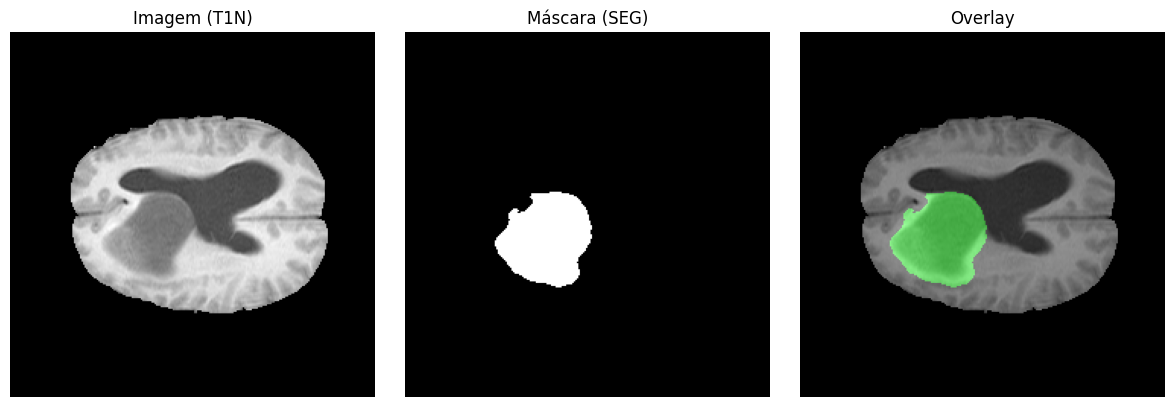

Paciente exibido: BraTS20_Training_234 | Split: test | Seq pedida: t1n | Seq usada: t1 | Slice: 1


In [31]:
# =====================
# Escolha do dataset
# =====================
BASE_PATH = CROSSDATASET      # pode ser BASELINE_2024 ou CROSSDATASET
SEQ = "t1n"                   # sequência escolhida (em formato 2024)
MASK_SEQ = "seg"

# =====================
# Sorteio do split e do paciente
# =====================
splits = ["train", "val", "test"]
split_escolhido = random.choice(splits)

split_dir = os.path.join(BASE_PATH, split_escolhido)
pacientes = [d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))]
assert len(pacientes) > 0, f"Nenhum paciente encontrado no split {split_escolhido}!"

paciente_escolhido = random.choice(pacientes)

# =====================
# Ajuste de equivalências (tenta 2020 ou 2024)
# =====================
aliases = [SEQ, seq_map_2024_to_2020.get(SEQ, SEQ), seq_map_2020_to_2024.get(SEQ, SEQ)]
aliases = list(dict.fromkeys(aliases))  # remove duplicados

img_dir = None
for alias in aliases:
    candidate = os.path.join(split_dir, paciente_escolhido, alias)
    if os.path.isdir(candidate):
        img_dir = candidate
        break

assert img_dir is not None, f"Nenhuma pasta encontrada para {SEQ} em {paciente_escolhido}!"

mask_dir = os.path.join(split_dir, paciente_escolhido, MASK_SEQ)
assert os.path.isdir(mask_dir), f"Nenhuma pasta de máscara encontrada em {paciente_escolhido}!"

# =====================
# Carregar arquivos
# =====================
img_files = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(".npy")])
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".npy")])

assert len(img_files) > 0, "Nenhuma slice encontrada para o paciente sorteado!"

# =====================
# Sorteio de 1 slice
# =====================
idx = random.choice(range(len(img_files)))
img = np.load(img_files[idx])
mask = np.load(mask_files[idx])

plt.figure(figsize=(12, 4))

# --- Imagem ---
plt.subplot(1, 3, 1)
plt.imshow(img, cmap="gray")
plt.title(f"Imagem ({SEQ.upper()})")
plt.axis("off")

# --- Máscara ---
plt.subplot(1, 3, 2)
plt.imshow(mask, cmap="gray")
plt.title("Máscara (SEG)")
plt.axis("off")

# --- Overlay ---
plt.subplot(1, 3, 3)
plt.imshow(img, cmap="gray")
green_layer = np.zeros((*mask.shape, 3), dtype=np.float32)
green_layer[..., 1] = mask / mask.max() if mask.max() > 0 else mask
plt.imshow(green_layer, alpha=0.4)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

print(f"Paciente exibido: {paciente_escolhido} | Split: {split_escolhido} | Seq pedida: {SEQ} | Seq usada: {os.path.basename(img_dir)} | Slice: {idx}")


In [32]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

# =====================
# Equivalências crossdataset
# =====================
seq_map_2020_to_2024 = {
    "t1": "t1n",
    "t1ce": "t1c",
    "t2": "t2w",
    "flair": "t2f"
}
seq_map_2024_to_2020 = {v: k for k, v in seq_map_2020_to_2024.items()}

# =====================
# Dataset customizado para crossdataset
# =====================
class CrossDataset(Dataset):
    def __init__(self, meta_csv, base_path, seq="t1n", mask="seg", size=(240,240), binarize=True):
        import pandas as pd
        self.meta = pd.read_csv(meta_csv)
        self.base_path = base_path
        self.seq = seq
        self.mask = mask
        self.size = size
        self.binarize = binarize

        # converte para padrão 2020 (se seq for 2024)
        seq_std = seq_map_2024_to_2020.get(seq, seq)

        # valida se existe no CSV
        if seq_std in self.meta.columns:
            self.seq_std = seq_std
        elif seq in self.meta.columns:
            self.seq_std = seq
        else:
            raise KeyError(
                f"Nenhuma coluna encontrada para {seq} ou {seq_std} em {meta_csv}. "
                f"Colunas disponíveis: {self.meta.columns.tolist()}"
            )

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]

        # Carregar imagem e máscara (.npy)
        img  = np.load(os.path.join(self.base_path, row[self.seq_std]))  # [H,W]
        mask = np.load(os.path.join(self.base_path, row[self.mask]))     # [H,W]

        # Normalizar imagem para [0,1]
        img = img.astype(np.float32)
        if img.max() > 0:
            img = img / img.max()

        # Normalizar máscara
        mask = mask.astype(np.float32)
        if self.binarize:
            mask = (mask > 0.5).astype(np.float32)

        # Redimensionar se necessário
        if img.shape != self.size:
            import cv2
            img  = cv2.resize(img,  self.size, interpolation=cv2.INTER_AREA)
            mask = cv2.resize(mask, self.size, interpolation=cv2.INTER_NEAREST)

        # Tensores [C,H,W]
        img_t  = torch.from_numpy(img).unsqueeze(0)   # [1,H,W]
        mask_t = torch.from_numpy(mask).unsqueeze(0)  # [1,H,W]

        return img_t, mask_t


# =====================
# Instanciando para treino, validação e teste (crossdataset T1n)
# =====================
CROSSDATASET = r"C:\Users\dados\Documents\mini_datasets\crossdataset"
train_csv = os.path.join(CROSSDATASET, "metadata_cross_train.csv")
val_csv   = os.path.join(CROSSDATASET, "metadata_cross_val.csv")
test_csv  = os.path.join(CROSSDATASET, "metadata_cross_test.csv")

IMG_SIZE = (240,240)

train_dataset = CrossDataset(train_csv, CROSSDATASET, seq="t1n", mask="seg", size=IMG_SIZE)
val_dataset   = CrossDataset(val_csv,   CROSSDATASET, seq="t1n", mask="seg", size=IMG_SIZE)
test_dataset  = CrossDataset(test_csv,  CROSSDATASET, seq="t1n", mask="seg", size=IMG_SIZE)


In [33]:

# =====================
# Blocos auxiliares
# =====================
class DoubleConv(nn.Module):
    """Dois convs 3x3 + BN + ReLU (+ dropout opcional)."""
    def __init__(self, in_ch, out_ch, p_drop=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=p_drop),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)


class UpBlock(nn.Module):
    """Upsample (ConvTranspose2d) + concat skip + DoubleConv."""
    def __init__(self, in_ch, out_ch, p_drop=0.0):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch=out_ch*2, out_ch=out_ch, p_drop=p_drop)

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            # corrige mismatch de tamanho por interpolação bilinear
            x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)


# =====================
# ResNet + U-Net decoder
# =====================
class ResNetUNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1,
                 pretrained=True, freeze_encoder=False,
                 return_logits=True, p_drop=0.0):
        super().__init__()

        # Backbone ResNet34
        weights = ResNet34_Weights.IMAGENET1K_V1 if pretrained else None
        self.backbone = models.resnet34(weights=weights)

        # Adapta a conv1 para grayscale (1 canal)
        if n_channels != 3:
            old_conv = self.backbone.conv1
            self.backbone.conv1 = nn.Conv2d(
                n_channels, old_conv.out_channels,
                kernel_size=old_conv.kernel_size,
                stride=old_conv.stride,
                padding=old_conv.padding,
                bias=False
            )
            if pretrained:
                with torch.no_grad():
                    if n_channels == 1:
                        # média dos pesos originais RGB -> 1 canal
                        self.backbone.conv1.weight[:] = old_conv.weight.mean(dim=1, keepdim=True)
                    else:
                        # caso fosse multispectral, faz repetição
                        rep = (n_channels + 2) // 3
                        w = old_conv.weight.repeat(1, rep, 1, 1)[:, :n_channels]
                        self.backbone.conv1.weight[:] = w / (3.0 / n_channels)

        # Congela encoder se solicitado
        if freeze_encoder:
            for p in self.backbone.parameters():
                p.requires_grad = False

        # Decoder tipo U-Net
        self.up4 = UpBlock(512, 256, p_drop=p_drop)
        self.up3 = UpBlock(256, 128, p_drop=p_drop)
        self.up2 = UpBlock(128, 64,  p_drop=p_drop)
        self.up1 = UpBlock(64,  64,  p_drop=p_drop)

        # Último upsample (H/2 → H)
        self.final_up = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.out_conv = nn.Conv2d(64, n_classes, kernel_size=1)

        self.return_logits = return_logits

    def encode(self, x):
        x0 = self.backbone.relu(self.backbone.bn1(self.backbone.conv1(x)))  # 64, H/2
        x1 = self.backbone.layer1(self.backbone.maxpool(x0))                # 64, H/4
        x2 = self.backbone.layer2(x1)                                       # 128, H/8
        x3 = self.backbone.layer3(x2)                                       # 256, H/16
        x4 = self.backbone.layer4(x3)                                       # 512, H/32
        return x0, x1, x2, x3, x4

    def forward(self, x):
        x0, x1, x2, x3, x4 = self.encode(x)
        x = self.up4(x4, x3)
        x = self.up3(x,  x2)
        x = self.up2(x,  x1)
        x = self.up1(x,  x0)
        x = self.final_up(x)             # volta para H×W
        logits = self.out_conv(x)
        return logits if self.return_logits else torch.sigmoid(logits)


# =====================
# Instanciando modelo
# =====================
DROPOUT_P = 0.2  # exemplo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpu_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"
print(f"Treinando em {device} ({gpu_name})")

model = ResNetUNet(
    n_channels=1,   # grayscale (T1 é 1 canal)
    n_classes=1,    # binária (tumor vs fundo)
    pretrained=True,
    freeze_encoder=False,
    return_logits=True,
    p_drop=DROPOUT_P
).to(device)


Treinando em cuda (NVIDIA GeForce RTX 4070 SUPER)


In [34]:
# -----------------
# Métricas
# -----------------
@torch.no_grad()
def dice_coeff_hard(logits_or_probs, target, threshold=0.5, eps=1e-6, from_logits=True):
    probs = torch.sigmoid(logits_or_probs) if from_logits else logits_or_probs
    target = target.float().to(probs.device)
    preds = (probs > threshold).float()

    # Corrige shape se precisar
    if preds.shape[-2:] != target.shape[-2:]:
        preds = F.interpolate(preds, size=target.shape[-2:], mode="nearest")

    dims = (1, 2, 3)  # (C,H,W)
    inter = (preds * target).sum(dims)
    denom = preds.sum(dims) + target.sum(dims)
    return ((2 * inter + eps) / (denom + eps)).mean()


def dice_coeff_soft(logits, target, eps=1e-6):
    probs = torch.sigmoid(logits)
    target = target.float()
    if probs.shape[-2:] != target.shape[-2:]:
        probs = F.interpolate(probs, size=target.shape[-2:], mode="bilinear", align_corners=False)
    dims = (1, 2, 3)
    inter = (probs * target).sum(dims)
    denom = probs.sum(dims) + target.sum(dims)
    return ((2 * inter + eps) / (denom + eps)).mean()


@torch.no_grad()
def iou_hard(logits_or_probs, target, thr=0.5, eps=1e-6, from_logits=True):
    probs = torch.sigmoid(logits_or_probs) if from_logits else logits_or_probs
    preds = (probs > thr).float()
    target = target.float().to(preds.device)

    dims = (1, 2, 3)
    inter = (preds * target).sum(dims)
    union = preds.sum(dims) + target.sum(dims) - inter
    return ((inter + eps) / (union + eps)).mean()


# -----------------
# Loss
# -----------------
class BCEWithLogitsDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5, pos_weight=None):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        self.bw = bce_weight
        self.dw = dice_weight

    def forward(self, logits, target):
        target = target.float()
        return (
            self.bw * self.bce(logits, target) +
            self.dw * (1.0 - dice_coeff_soft(logits, target))
        )

In [35]:
import torch
import torch.nn.functional as F
from torch import optim
from torch.cuda.amp import GradScaler
from torch.utils.data import DataLoader

# =====================
# Configurações
# =====================
BATCH_SIZE = 32
LR = 1e-3
WEIGHT_DECAY = 1e-5

# =====================
# DataLoaders (usando diretamente os splits já existentes)
# =====================
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=0, pin_memory=(device=="cuda")
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=0, pin_memory=(device=="cuda")
)
test_loader = DataLoader(
    test_dataset, batch_size=1, shuffle=False,
    num_workers=0, pin_memory=(device=="cuda")
)

# =====================
# Loss + Optimizer + Scheduler
# =====================
criterion = BCEWithLogitsDiceLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min',
    factor=0.5, patience=3, verbose=True, min_lr=1e-6
)

# =====================
# Mixed precision (AMP)
# =====================
scaler = GradScaler(enabled=(device=="cuda"))

print(f"Treino baseline2020 - T1/Seg | "
      f"Treino: {len(train_dataset)}, "
      f"Validação: {len(val_dataset)}, "
      f"Teste: {len(test_dataset)}")


Treino baseline2020 - T1/Seg | Treino: 4320, Validação: 1080, Teste: 1400


C:\Users\dados\anaconda3\envs\Torch\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\dados\AppData\Local\Temp\ipykernel_12444\1060495304.py:44: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device=="cuda"))


In [36]:
import torch
import torch.nn as nn
from torch.cuda.amp import autocast

# =====================
# Funções auxiliares
# =====================
def random_aug(imgs, masks):
    """Aumentações simples: flips, rotação, ruído leve"""
    if torch.rand(1) < 0.5:  # flip horizontal
        imgs  = torch.flip(imgs, dims=[3])
        masks = torch.flip(masks, dims=[3])
    if torch.rand(1) < 0.5:  # flip vertical
        imgs  = torch.flip(imgs, dims=[2])
        masks = torch.flip(masks, dims=[2])
    if torch.rand(1) < 0.25:  # rotação 90°
        imgs  = imgs.transpose(2,3)
        masks = masks.transpose(2,3)
    if torch.rand(1) < 0.3:   # ruído leve
        imgs = torch.clamp(imgs + 0.05 * torch.randn_like(imgs), 0.0, 1.0)
    return imgs, masks

class EarlyStopping:
    """Monitora val_loss, guarda melhor modelo"""
    def __init__(self, patience=8):
        self.best = None
        self.count = 0
        self.best_state = None
        self.patience = patience
    def step(self, metric, model):
        if (self.best is None) or (metric < self.best):
            self.best = metric
            self.count = 0
            self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            return True
        else:
            self.count += 1
            return False
    def should_stop(self): return self.count >= self.patience

def set_encoder_trainable(m, flag: bool):
    """Liga/desliga o treinamento do encoder ResNet"""
    for p in m.backbone.parameters():
        p.requires_grad = flag

# =====================
# Treinamento
# =====================
N_EPOCHS = 80
early = EarlyStopping(patience=8)

for epoch in range(N_EPOCHS):
    # Warmup: encoder congelado nas 2 primeiras épocas
    set_encoder_trainable(model, flag=(epoch >= 2))

    # ===== Treino =====
    model.train()
    train_loss = 0.0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        imgs, masks = random_aug(imgs, masks)

        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=(device=="cuda")):
            logits = model(imgs)
            loss = criterion(logits, masks)

        scaler.scale(loss).backward()
        # Grad clipping
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    # ===== Validação =====
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            val_loss += criterion(logits, masks).item()
            val_dice += dice_coeff_hard(logits, masks, threshold=0.5, from_logits=True).item()

    train_loss /= max(1, len(train_loader))
    val_loss   /= max(1, len(val_loader))
    val_dice   /= max(1, len(val_loader))

    print(f"Epoch {epoch+1:02d}/{N_EPOCHS} | "
          f"train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_dice={val_dice:.4f}")

    scheduler.step(val_loss)
    improved = early.step(val_loss, model)
    if early.should_stop():
        print("⏹ Early stopping acionado.")
        break

# Carrega melhor estado (menor val_loss)
if early.best_state is not None:
    model.load_state_dict(early.best_state)
    model.to(device)
    print("✅ Melhor modelo carregado (menor val_loss).")


C:\Users\dados\AppData\Local\Temp\ipykernel_12444\2524051225.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device=="cuda")):


Epoch 01/80 | train_loss=0.4107 | val_loss=0.3332 | val_dice=0.4895
Epoch 02/80 | train_loss=0.3085 | val_loss=0.2875 | val_dice=0.5064
Epoch 03/80 | train_loss=0.2877 | val_loss=0.2922 | val_dice=0.4933
Epoch 04/80 | train_loss=0.2561 | val_loss=0.2565 | val_dice=0.5452
Epoch 05/80 | train_loss=0.2452 | val_loss=0.2560 | val_dice=0.5380
Epoch 06/80 | train_loss=0.2310 | val_loss=0.2389 | val_dice=0.5794
Epoch 07/80 | train_loss=0.2209 | val_loss=0.2466 | val_dice=0.5678
Epoch 08/80 | train_loss=0.2179 | val_loss=0.2361 | val_dice=0.5839
Epoch 09/80 | train_loss=0.2192 | val_loss=0.2483 | val_dice=0.5533
Epoch 10/80 | train_loss=0.2134 | val_loss=0.2461 | val_dice=0.5650
Epoch 11/80 | train_loss=0.2087 | val_loss=0.2504 | val_dice=0.5618
Epoch 12/80 | train_loss=0.2088 | val_loss=0.2228 | val_dice=0.6054
Epoch 13/80 | train_loss=0.2045 | val_loss=0.2146 | val_dice=0.6195
Epoch 14/80 | train_loss=0.1998 | val_loss=0.2279 | val_dice=0.6017
Epoch 15/80 | train_loss=0.2002 | val_loss=0.227

Amostra de teste escolhida: idx=391 (0..1399)
Dice: 0.7897 | IoU: 0.1846


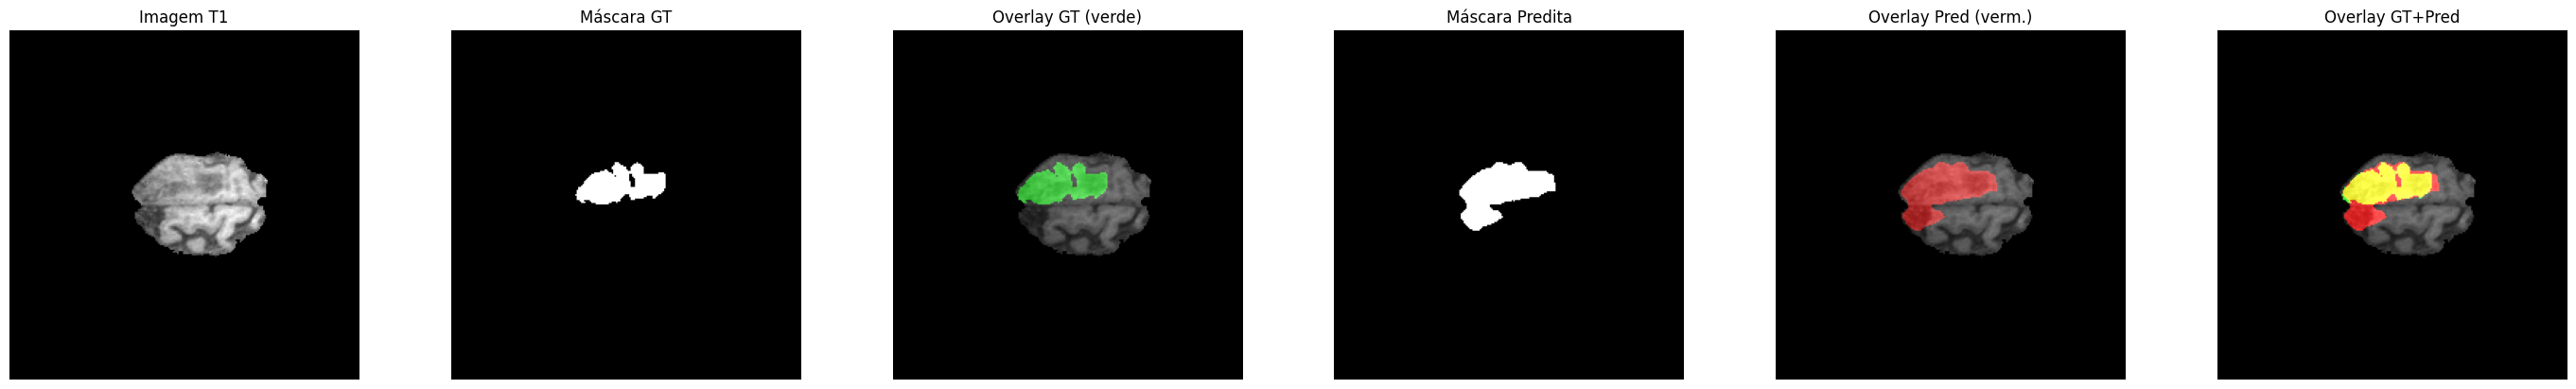

In [40]:
# =====================
# Teste no baseline2020 (T1 vs Seg)
# =====================
model.eval()

# Pegar amostra aleatória do conjunto de teste
idx = random.randrange(len(test_dataset))
img, mask = test_dataset[idx]  # tensores [1,H,W]
print(f"Amostra de teste escolhida: idx={idx} (0..{len(test_dataset)-1})")

# Forward
with torch.no_grad():
    logit = model(img.unsqueeze(0).to(device))   # [1,1,H,W]
    prob  = torch.sigmoid(logit).cpu()
pred_bin = (prob > 0.5).float()

# =====================
# Métricas
# =====================
dice = dice_coeff_hard(prob, mask.unsqueeze(0), threshold=0.5, from_logits=False).item()
iou  = iou_hard(prob, mask.unsqueeze(0), thr=0.5).item()
print(f"Dice: {dice:.4f} | IoU: {iou:.4f}")

# =====================
# Funções de overlay
# =====================
def overlay_color(img_01CHW, mask_01CHW, color=(0,1,0), alpha=0.5):
    """Overlay de uma máscara em uma cor RGB"""
    img2d  = img_01CHW.squeeze().cpu().numpy().astype(np.float32)
    mask2d = mask_01CHW.squeeze().cpu().numpy().astype(np.float32)
    img_rgb = np.stack([img2d]*3, axis=-1)
    color_img = np.zeros_like(img_rgb, dtype=np.float32)
    for c in range(3):
        color_img[..., c] = color[c] * mask2d
    return np.clip(img_rgb*(1-alpha) + color_img*alpha, 0, 1)

def overlay_both(img_01CHW, gt_01CHW, pred_01CHW, alpha_img=0.5, alpha_masks=0.7):
    """GT em verde, Pred em vermelho"""
    img2d = img_01CHW.squeeze().cpu().numpy().astype(np.float32)
    gt2d  = gt_01CHW.squeeze().cpu().numpy().astype(np.float32)
    pr2d  = pred_01CHW.squeeze().cpu().numpy().astype(np.float32)
    img_rgb = np.stack([img2d]*3, axis=-1)
    color = np.zeros_like(img_rgb, dtype=np.float32)
    color[..., 0] = pr2d   # vermelho = pred
    color[..., 1] = gt2d   # verde = GT
    return np.clip(img_rgb*alpha_img + color*alpha_masks, 0, 1)

# =====================
# Criar overlays
# =====================
overlay_gt_green = overlay_color(img, mask,               color=(0,1,0), alpha=0.5)
overlay_pred_red = overlay_color(img, pred_bin.squeeze(0),color=(1,0,0), alpha=0.5)
overlay_combo    = overlay_both (img, mask, pred_bin.squeeze(0))

# =====================
# Plot lado a lado
# =====================
fig, axes = plt.subplots(1, 6, figsize=(28, 4), constrained_layout=True)

axes[0].imshow(img.squeeze(),  cmap="gray");     axes[0].set_title("Imagem T1");          axes[0].axis("off")
axes[1].imshow(mask.squeeze(), cmap="gray");     axes[1].set_title("Máscara GT");         axes[1].axis("off")
axes[2].imshow(overlay_gt_green);                axes[2].set_title("Overlay GT (verde)"); axes[2].axis("off")
axes[3].imshow(pred_bin.squeeze(), cmap="gray"); axes[3].set_title("Máscara Predita");    axes[3].axis("off")
axes[4].imshow(overlay_pred_red);                axes[4].set_title("Overlay Pred (verm.)"); axes[4].axis("off")
axes[5].imshow(overlay_combo);                   axes[5].set_title("Overlay GT+Pred");    axes[5].axis("off")

plt.show()


Exibindo: Melhor, Melhor, Aleatório, Aleatório, Aleatório, Aleatório, Pior, Pior


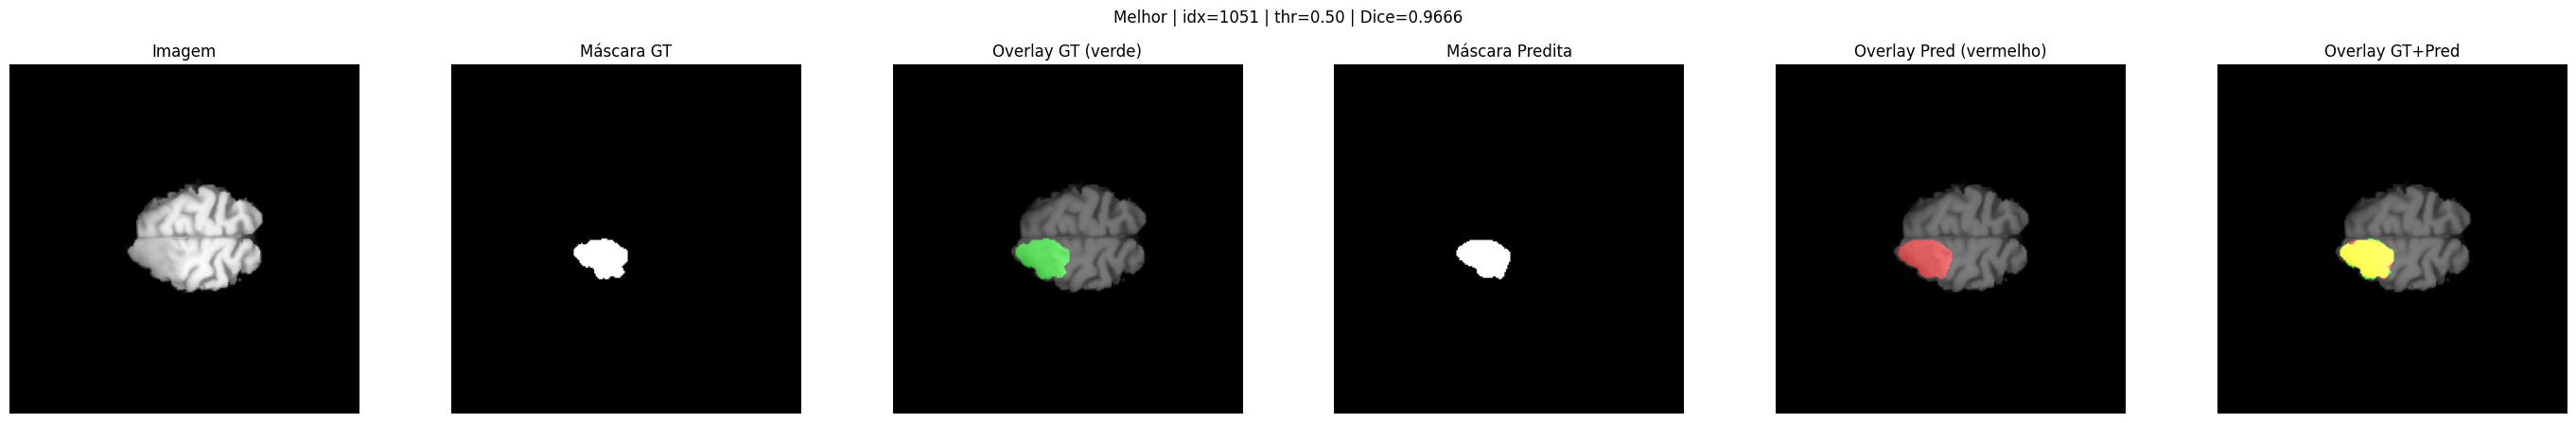

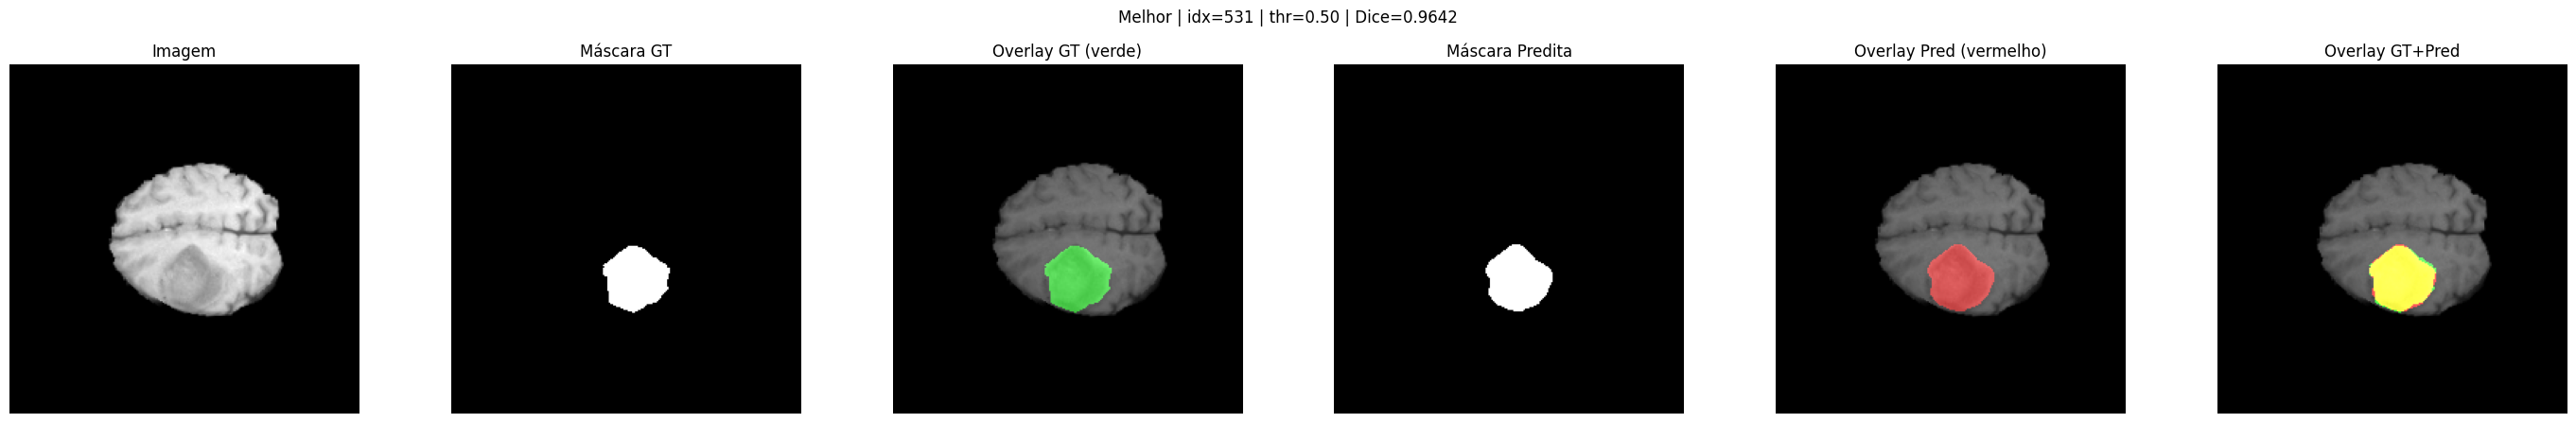

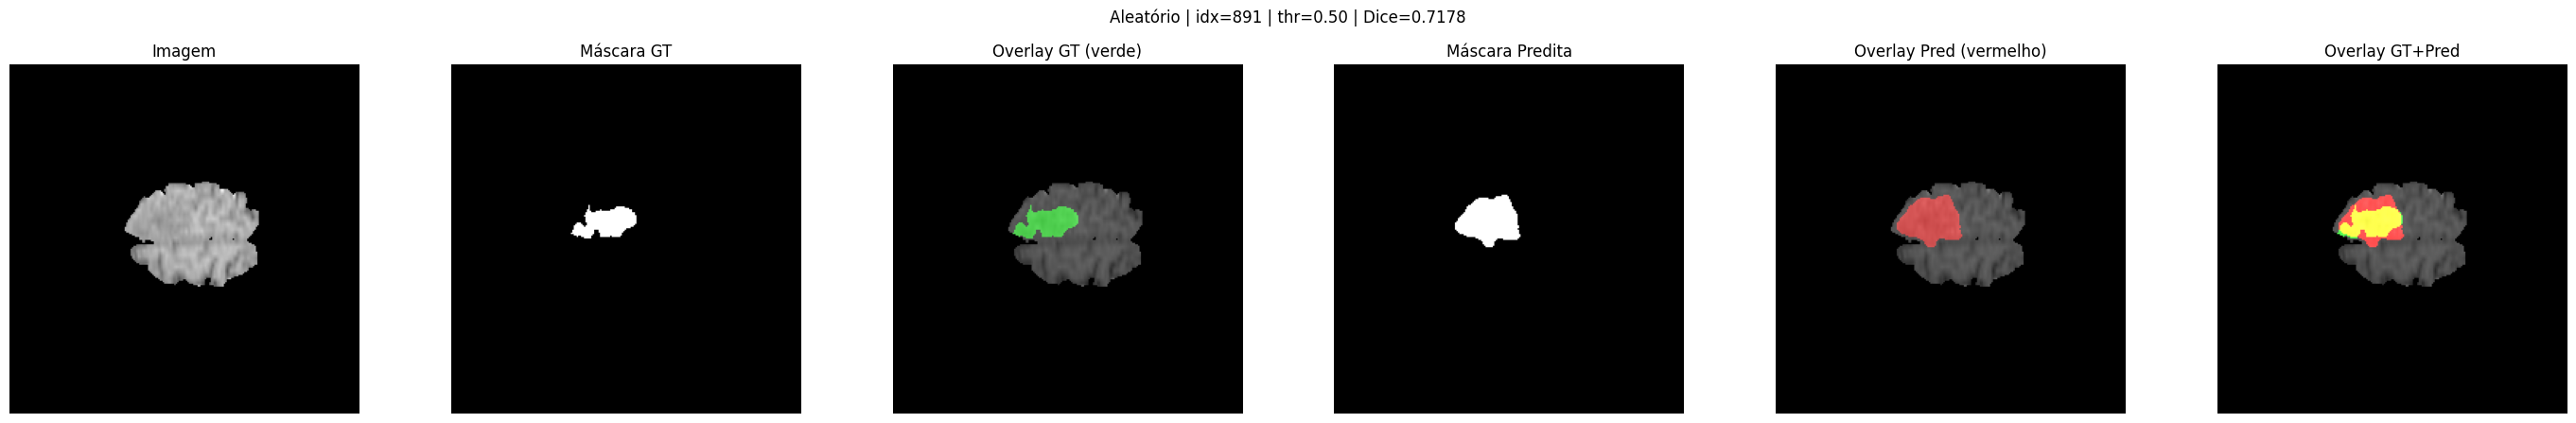

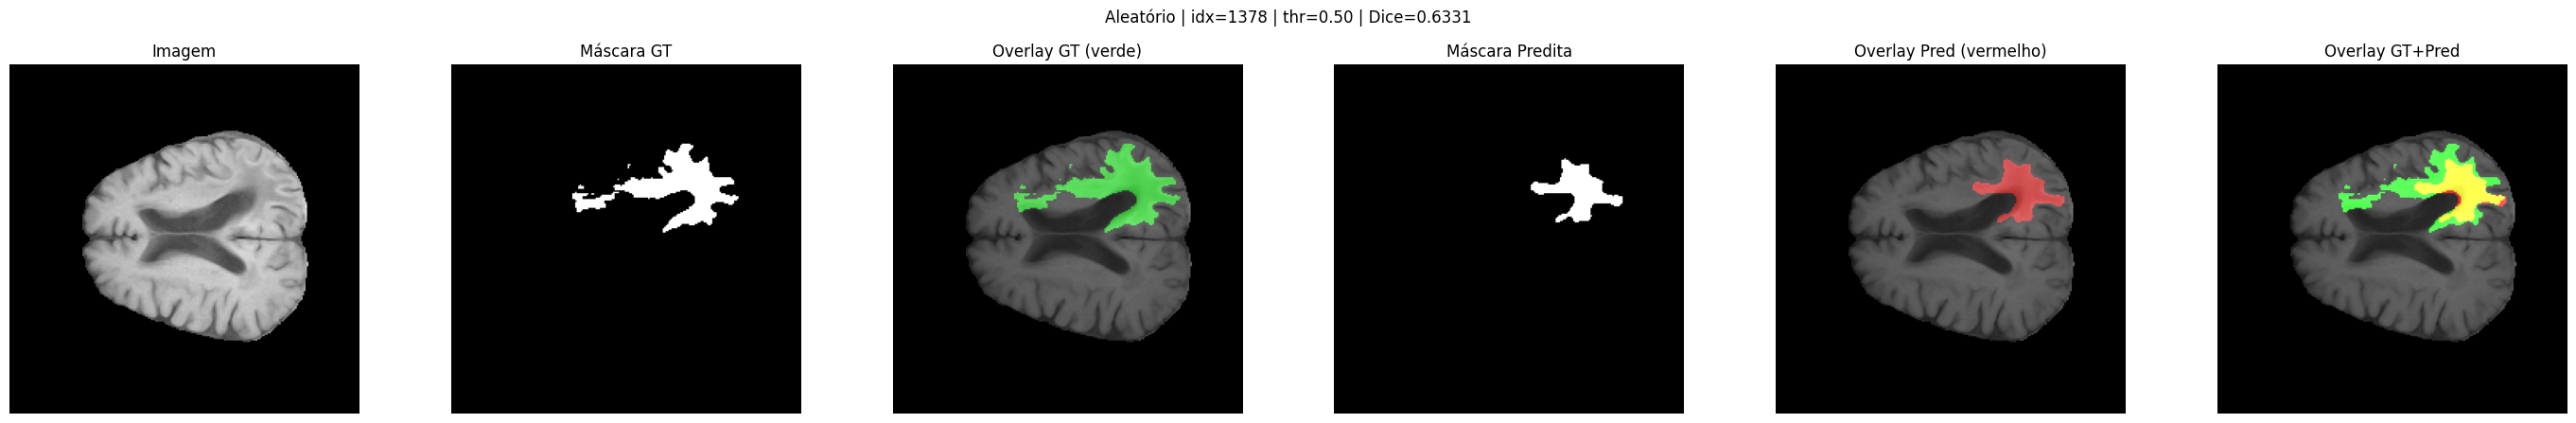

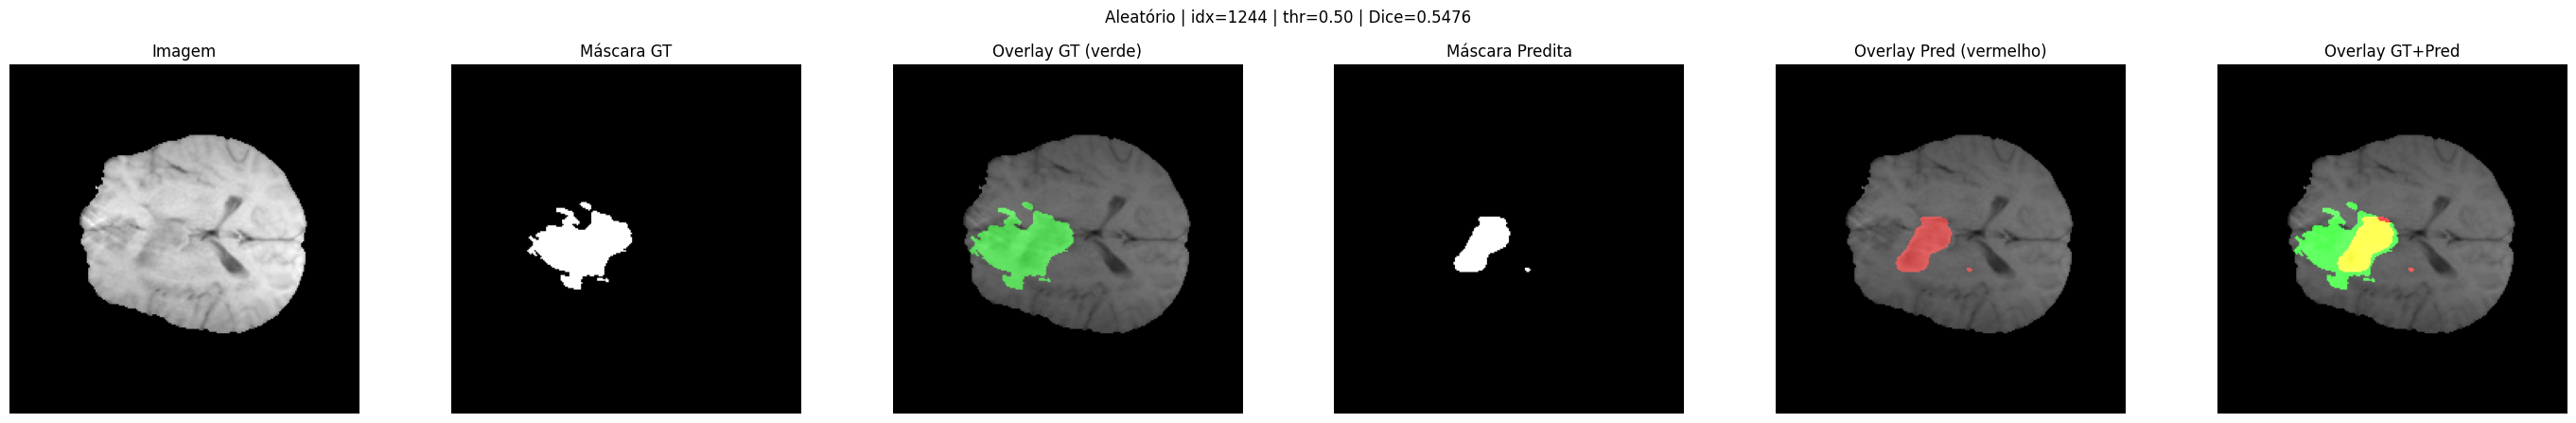

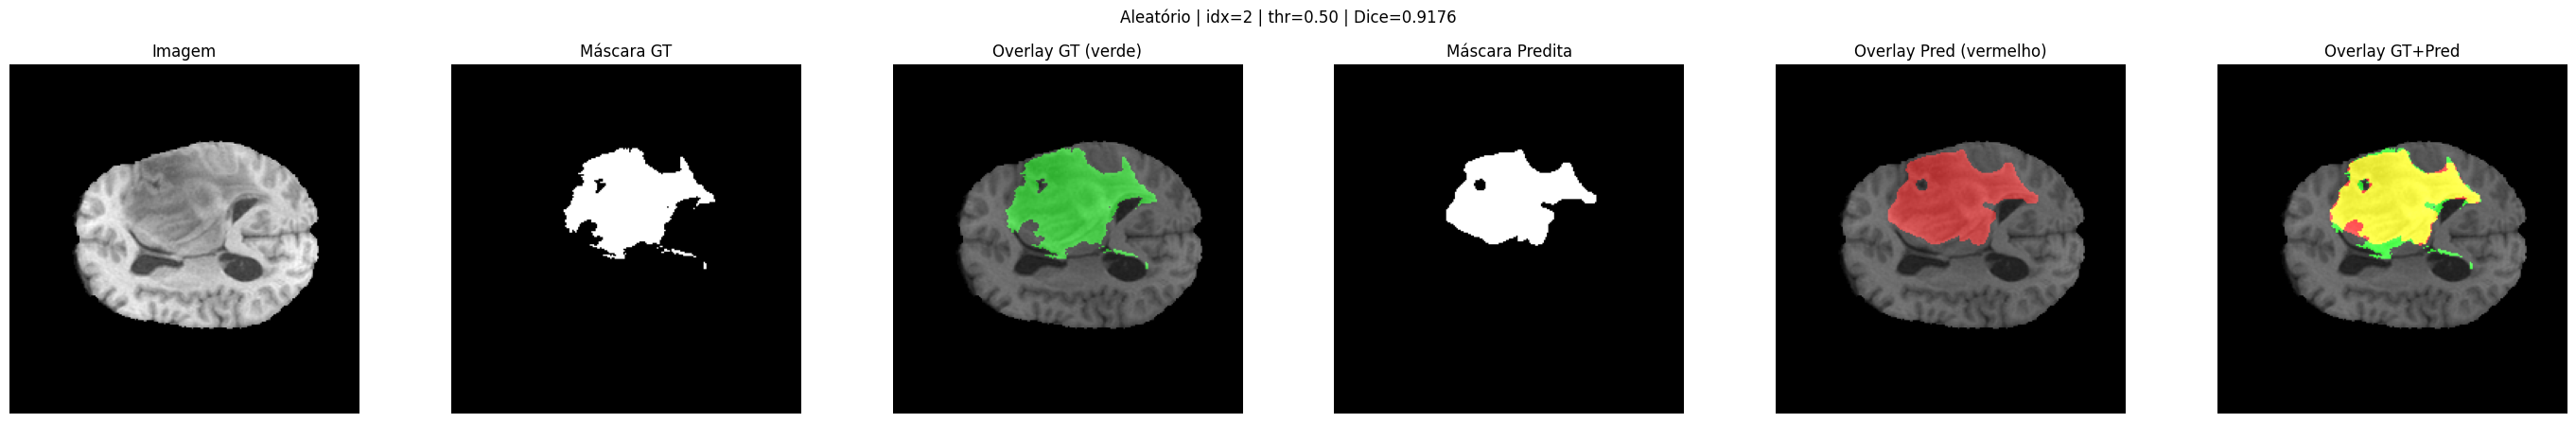

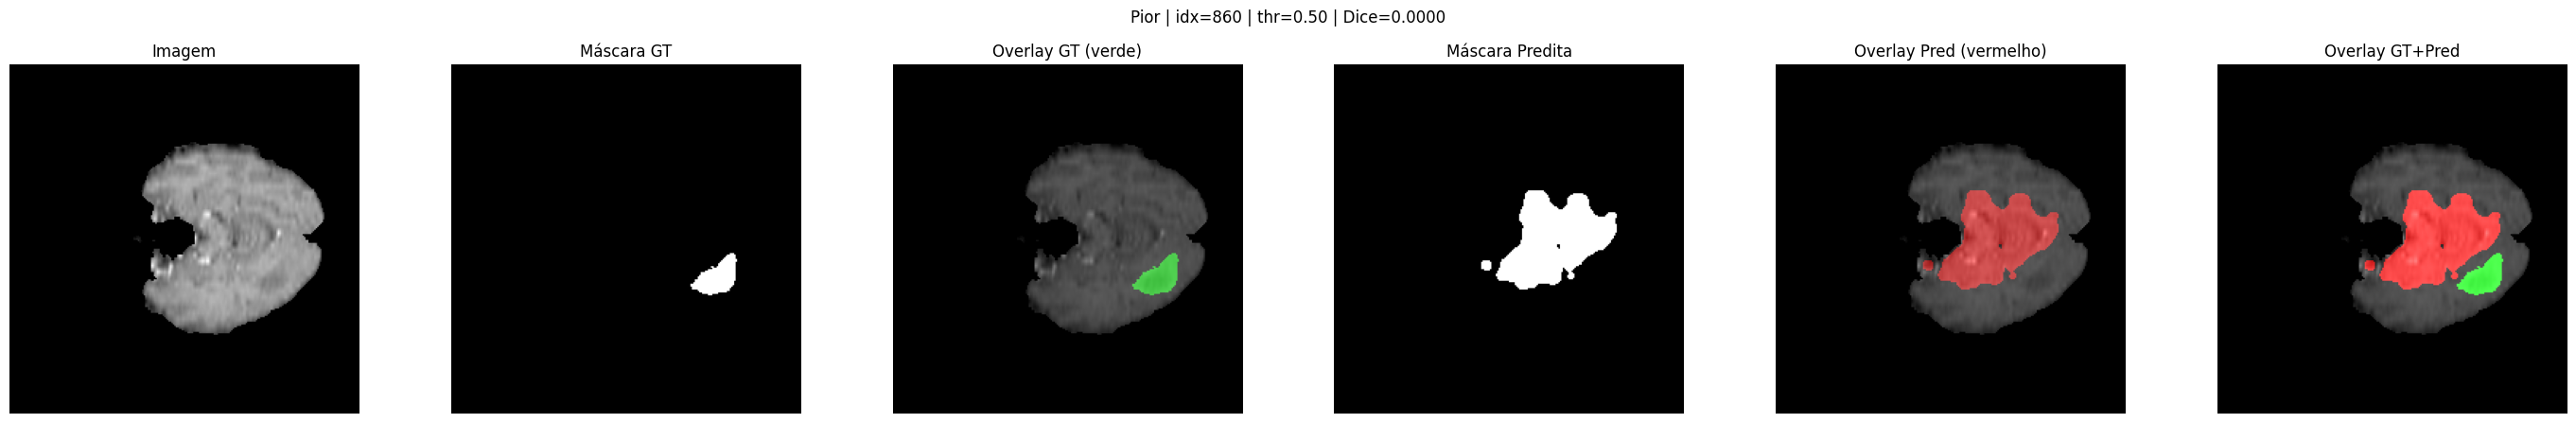

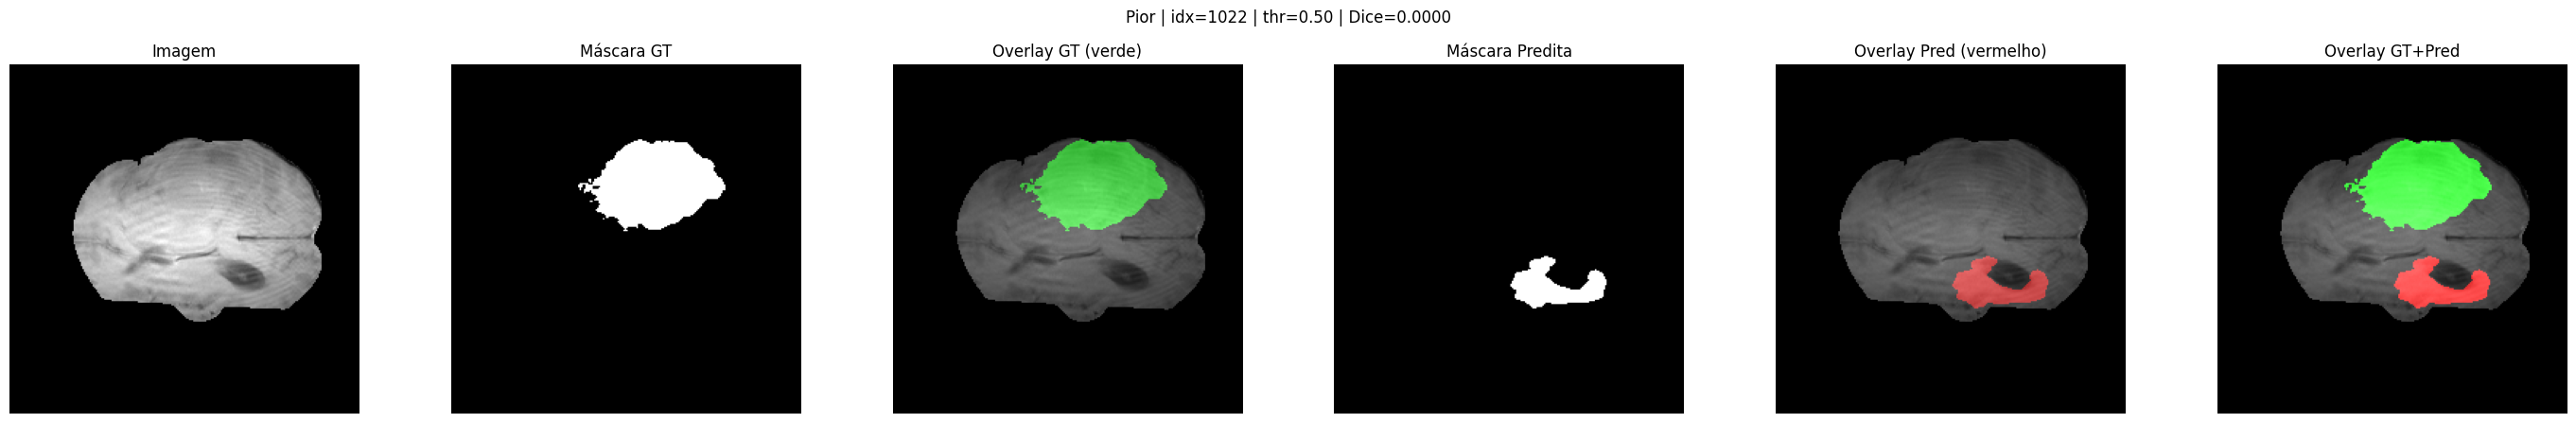

In [38]:
# Exibir: melhor, melhor, aleatório x4, pior, pior
# Garante o ranking (se ainda não existir)
if 'results_sorted' not in globals() or len(results_sorted) == 0:
    results = []
    model.eval()
    with torch.no_grad():
        for idx in range(len(test_dataset)):
            im, gt = test_dataset[idx]
            im = im.to(device)
            gt = gt.to(device)
            logit = model(im.unsqueeze(0))
            d = dice_coeff_hard(logit, gt.unsqueeze(0), threshold=0.5, from_logits=True).item()
            results.append((idx, d))
    results_sorted = sorted(results, key=lambda x: x[1], reverse=True)

# Pega 2 melhores e 2 piores com segurança
best2  = results_sorted[:2] if len(results_sorted) >= 2 else results_sorted[:1]
worst2 = results_sorted[-2:] if len(results_sorted) >= 2 else results_sorted[-1:]

# Se houver menos que 2, duplica para preencher
while len(best2)  < 2 and len(results_sorted) > 0: best2  += best2[:1]
while len(worst2) < 2 and len(results_sorted) > 0: worst2 += worst2[:1]

# Amostra 4 aleatórios que NÃO sejam os extremos
extreme_idxs = {i for i, _ in (best2 + worst2)}
pool = [i for i in range(len(test_dataset)) if i not in extreme_idxs]

if len(pool) >= 4:
    rand4 = random.sample(pool, 4)
elif len(pool) > 0:
    # se o pool for pequeno, amostra com reposição
    rand4 = [random.choice(pool) for _ in range(4)]
else:
    # fallback raro (dataset minúsculo): reutiliza algum índice existente
    fallback = list(extreme_idxs) or [0]
    rand4 = [random.choice(fallback) for _ in range(4)]

# Ordem solicitada: melhor, melhor, aleatório*4, pior, pior
order = [
    best2[0][0], best2[1][0],
    rand4[0], rand4[1], rand4[2], rand4[3],
    worst2[0][0], worst2[1][0],
]

# Labels para o título
labels = {
    best2[0][0]:  "Melhor",
    best2[1][0]:  "Melhor",
    worst2[0][0]: "Pior",
    worst2[1][0]: "Pior",
}

thr_val = BEST_THR if 'BEST_THR' in globals() else 0.5
print("Exibindo: Melhor, Melhor, Aleatório, Aleatório, Aleatório, Aleatório, Pior, Pior")

for idx in order:
    title = labels.get(idx, "Aleatório")

    # pega dados
    im, gt = test_dataset[idx]                         # CPU [1,H,W] em [0,1]
    with torch.no_grad():
        logit = model(im.unsqueeze(0).to(device))
        prob  = torch.sigmoid(logit).cpu()             # [1,1,H,W]
    predb = (prob > thr_val).float()                   # [1,1,H,W]

    # métricas para título
    d = dice_coeff_hard(prob, gt.unsqueeze(0), threshold=thr_val, from_logits=False).item()

    # overlays no padrão pedido
    overlay_gt_green = overlay_color(im, gt,                 color=(0,1,0), alpha=0.5)
    overlay_pred_red = overlay_color(im, predb.squeeze(0),   color=(1,0,0), alpha=0.5)
    overlay_combo    = overlay_both (im, gt, predb.squeeze(0))

    # plot 1x6 lado a lado
    fig, axes = plt.subplots(1, 6, figsize=(28, 4), constrained_layout=True)
    fig.suptitle(f"{title} | idx={idx} | thr={thr_val:.2f} | Dice={d:.4f}", y=1.08)

    axes[0].imshow(im.squeeze(),  cmap="gray");                  axes[0].set_title("Imagem");                  axes[0].axis("off")
    axes[1].imshow(gt.squeeze(),  cmap="gray");                  axes[1].set_title("Máscara GT");              axes[1].axis("off")
    axes[2].imshow(overlay_gt_green);                            axes[2].set_title("Overlay GT (verde)");      axes[2].axis("off")
    axes[3].imshow(predb.cpu().squeeze().numpy(), cmap="gray");  axes[3].set_title("Máscara Predita");         axes[3].axis("off")
    axes[4].imshow(overlay_pred_red);                            axes[4].set_title("Overlay Pred (vermelho)"); axes[4].axis("off")
    axes[5].imshow(overlay_combo);                               axes[5].set_title("Overlay GT+Pred");         axes[5].axis("off")

    plt.show()


In [39]:
# =====================
# Avaliação no baseline2020 - T1/Seg
# =====================
model.eval()

metrics = {
    "dice": [],
    "iou": [],
    "acc": []
}

with torch.no_grad():
    for imgs, masks in test_loader:   # percorre todo o split de teste
        imgs, masks = imgs.to(device), masks.to(device)

        # forward
        logits = model(imgs)
        probs  = torch.sigmoid(logits)
        preds  = (probs > 0.5).float()

        # ajusta shapes se necessário
        if preds.shape[-2:] != masks.shape[-2:]:
            preds = F.interpolate(preds, size=masks.shape[-2:], mode="nearest")

        # métricas por batch
        dice = dice_coeff_hard(probs, masks, threshold=0.5, from_logits=False).item()
        iou  = iou_hard(probs, masks, thr=0.5).item()

        # acurácia pixel a pixel
        correct = (preds == masks).sum().item()
        total   = masks.numel()
        acc     = correct / total

        metrics["dice"].append(dice)
        metrics["iou"].append(iou)
        metrics["acc"].append(acc)

# =====================
# Consolidar em DataFrame
# =====================
df_results = pd.DataFrame([{
    "Dice":  np.mean(metrics["dice"]),
    "IoU":   np.mean(metrics["iou"]),
    "Acc":   np.mean(metrics["acc"])
}])

display(df_results)


,Dice,IoU,Acc
0,0.614852,0.091668,0.986426
